In [1]:
import visualID as vID
vID.init()

**Début à:** Wednesday 15 June 2022, 17:34:00  
**Hostname:** insa-11357 (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoBegin.svg" style="margin-left:auto; margin-right:auto"></img></p>

# Prediction of CO<sub>2</sub> solubility with an ANN
**Reference**: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [*Chem. Eng. Sci.* **223**: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 

In [2]:
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import os,sys
from IPython.display import display

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   OFF = '\033[0m'

<a id="data-read"></a>
## **1.** Basic data analysis and visualization
The [pandas library](https://pandas.pydata.org/docs/index.html) provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language. It is recommended to first have a look at the [10mn short introduction to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).
### **1.a.** Read the database

In [3]:
dataCO2f='dataCO2_solubility'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **1.b.** Read the SMILES of the cations and anions

In [5]:
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
print(rdkit.__version__)
SMILESCO2='dataCO2_solubility'+'/'+'dataCO2_SMILES_ILsList.csv'
SMILESCO2=pd.read_csv(SMILESCO2,sep="\t",header=0)
SMILESCO2.head(2)

2022.03.2


,Cation or Anion,Abbreviation,Full Name,SMILES
0,Cation,[MMIM],"1,3-dimethyl-imidazolium",[N+]1(C)=CN(C=C1)C
1,Cation,[EMIM],1-ethyl-3-methyl-imidazolium,[N+]1(CC)=CN(C=C1)C


(56, 5)


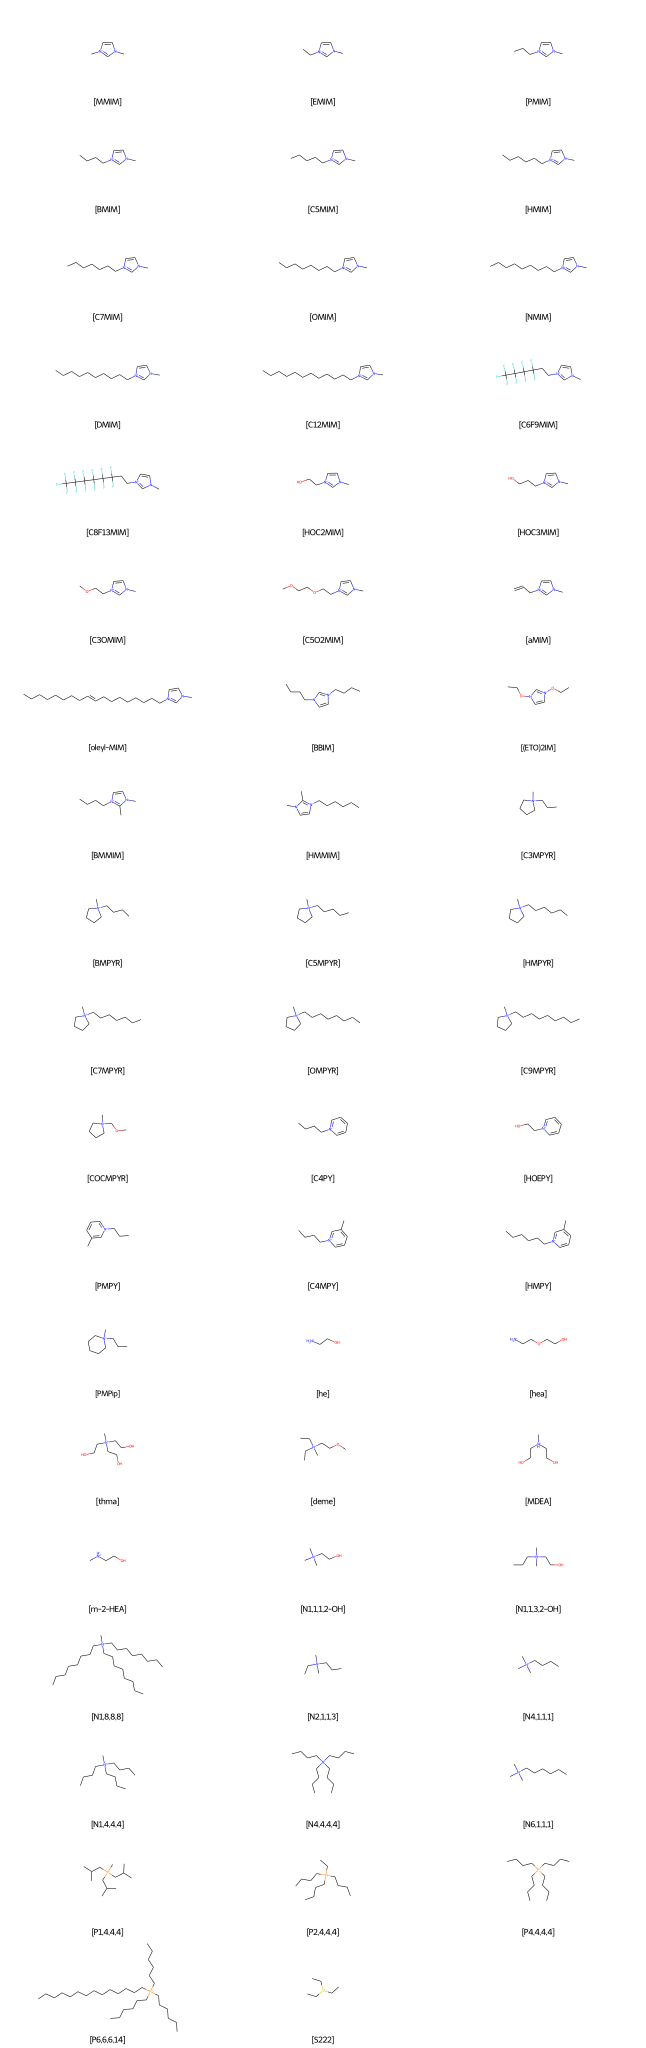

In [6]:
PandasTools.AddMoleculeColumnToFrame(SMILESCO2, smilesCol='SMILES')
ILcation=SMILESCO2[SMILESCO2['Cation or Anion'] == 'Cation']
print(ILcation.shape)
IPythonConsole.drawOptions.bondLineWidth=1
PandasTools.FrameToGridImage(ILcation, molsPerRow=3, legendsCol='Abbreviation',useSVG=True, subImgSize=(400, 200), maxMols=ILcation.shape[0])

(28, 5)


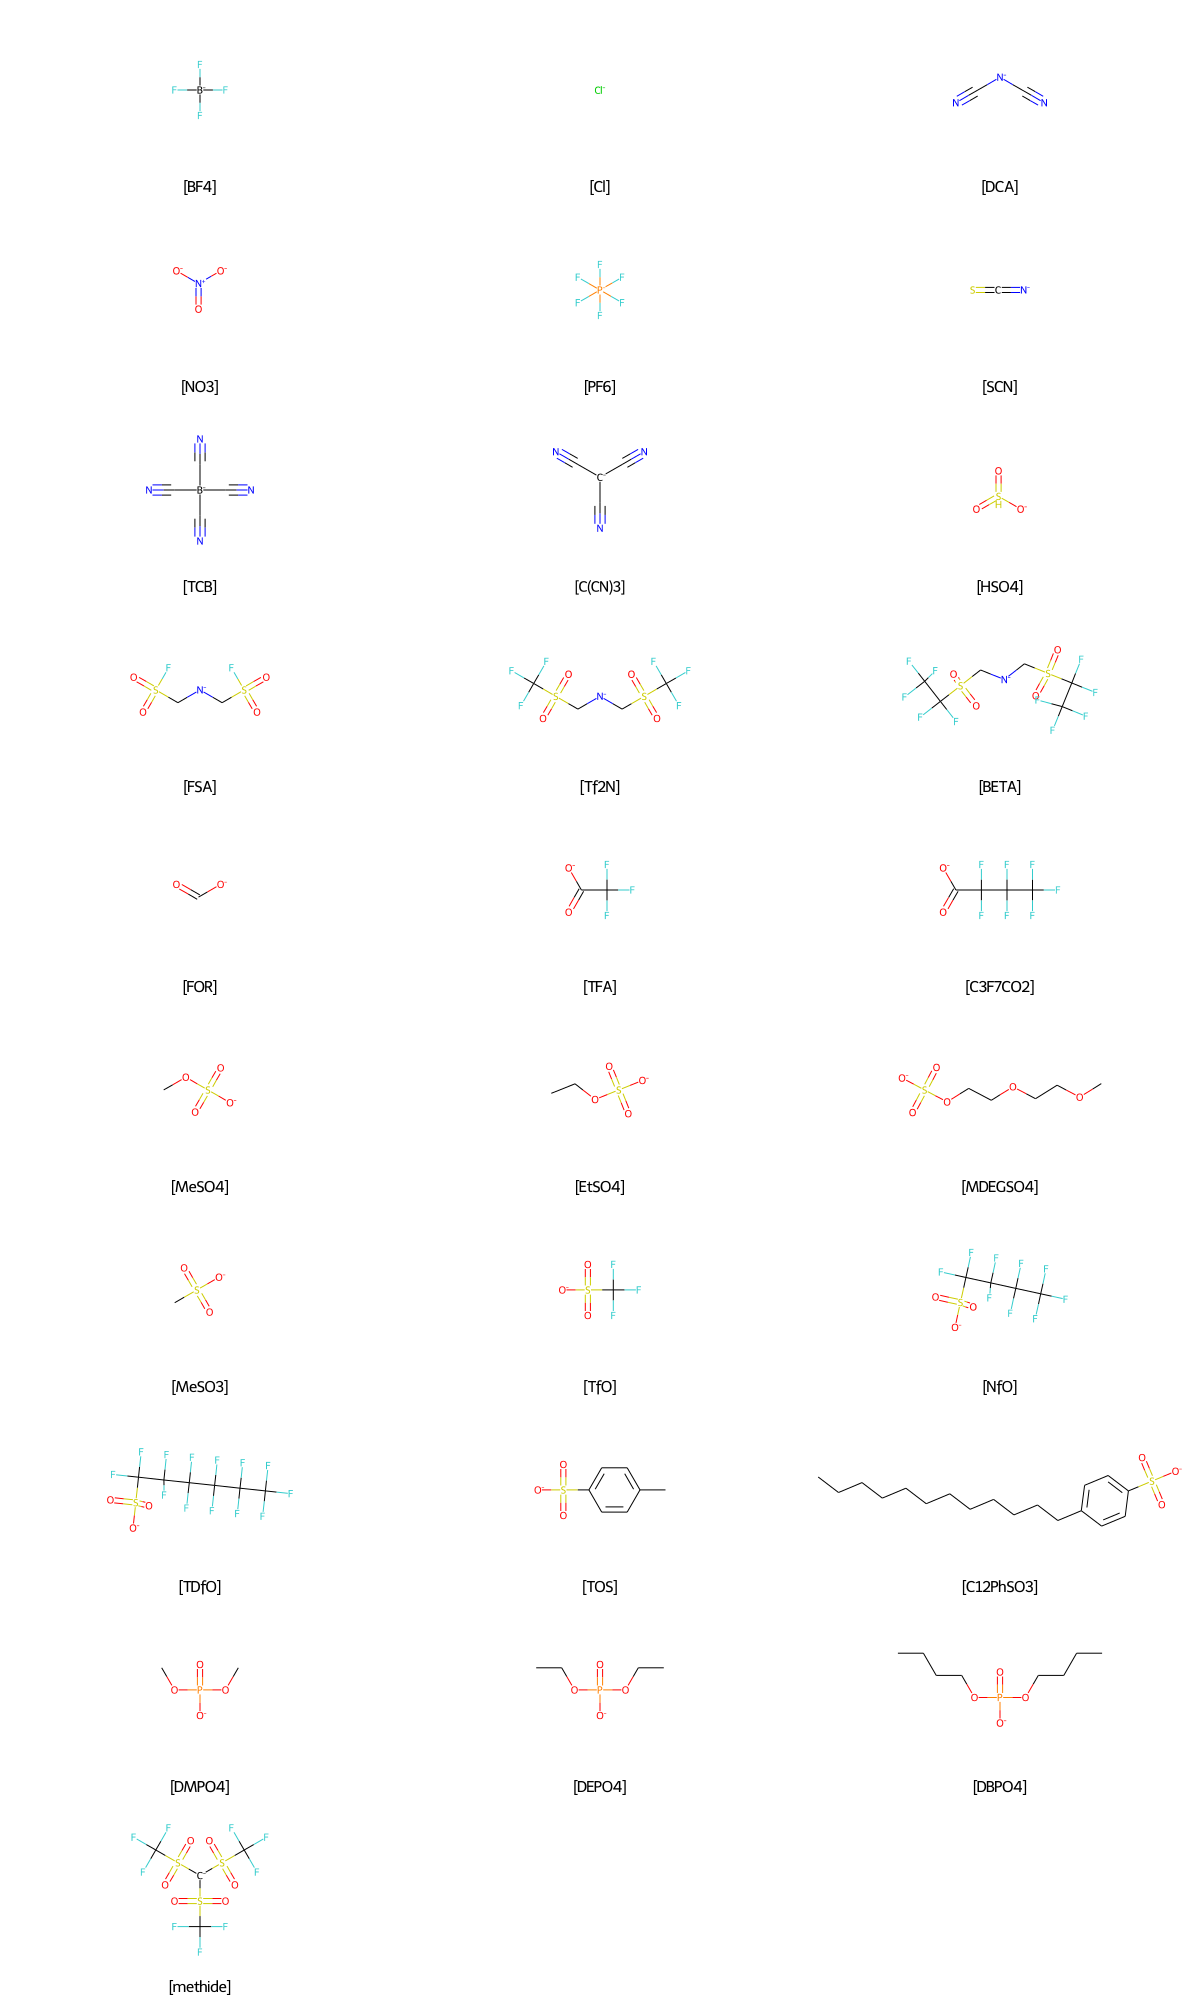

In [7]:
ILanion=SMILESCO2[SMILESCO2['Cation or Anion'] == 'Anion']
print(ILanion.shape)
IPythonConsole.drawOptions.bondLineWidth=1
PandasTools.FrameToGridImage(ILanion, molsPerRow=3, legendsCol='Abbreviation', useSVG=True, subImgSize=(400, 200), maxMols=ILcation.shape[0])

### **1.c.** Any correlation between data?

       x_CO2
[CH3]       
0        855
1       8350
2        108
3         92
4        639
7         72

Duration :  00:00:03 648ms


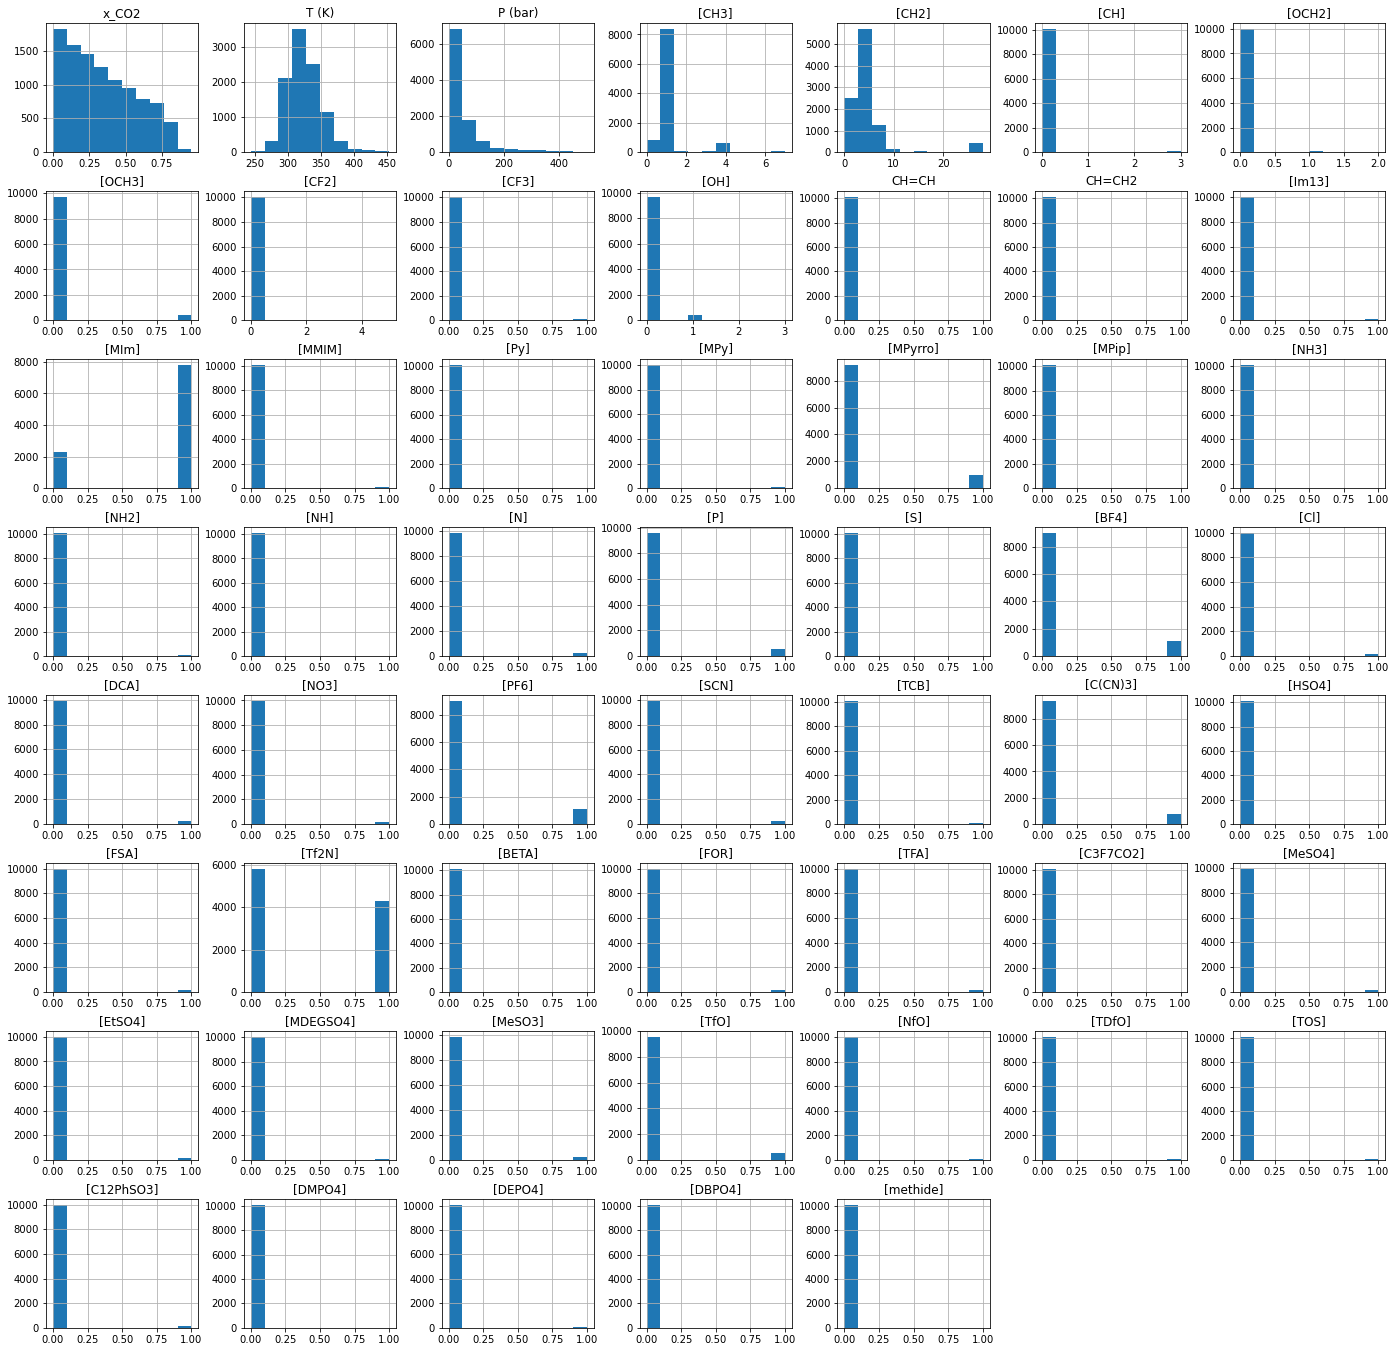

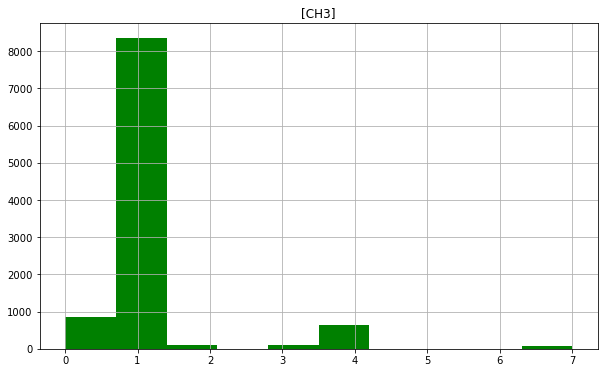

In [8]:
vID.chrono_start()
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')
vID.chrono_show()

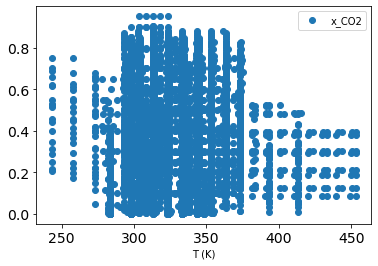

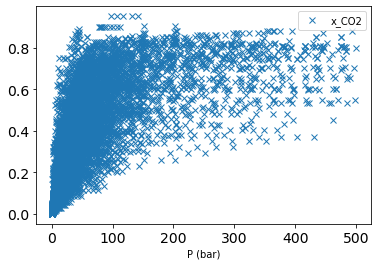

In [9]:
fig1=dataCO2.plot(x="T (K)", y=["x_CO2"],linestyle='', marker='o',fontsize=14)
fig2=dataCO2.plot(x="P (bar)", y=["x_CO2"],linestyle='', marker='x',fontsize=14)

<a id="data-prep"></a>
## **2.** Machine learning part: **preparation of the data**

### **2.a.** Shuffle and Split => train, test

In [10]:
data       = dataCO2.sample(frac=1., axis=0)
data_train = dataCO2.sample(frac=0.8, axis=0)
print(data_train.index)
data_test  = dataCO2.drop(data_train.index)
print(data_test.index)

Int64Index([8279, 9177,  926, 8550,  714, 7609, 5542, 7342, 6241,  905,
            ...
            5514,  813, 2672, 7182,  281, 8261, 7879, 3565, 5738, 6168],
           dtype='int64', length=8093)
Int64Index([    7,    13,    14,    26,    29,    30,    35,    40,    41,
               43,
            ...
            10087, 10090, 10092, 10093, 10095, 10100, 10104, 10107, 10109,
            10114],
           dtype='int64', length=2023)


### **2.b.** Split x & y
**x** are all functional descriptors  
**y** is x_CO2

In [11]:
x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
display(x_train)
print('y_train')
display(y_train)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
print('x_test')
display(x_test)
print('y_test')
display(y_test)

Original data shape was :  (10116, 57)
x_train :  (8093, 53) y_train :  (8093,)


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
8279,343.15,0.100,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9177,310.10,0.499,1,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
926,283.15,2.000,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8550,318.20,31.200,1,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
714,298.15,12.000,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8261,313.15,6.999,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7879,308.15,20.000,1,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3565,322.00,63.940,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5738,353.15,54.800,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


y_train


8279    0.0020
9177    0.0203
926     0.0512
8550    0.1043
714     0.1730
         ...  
8261    0.1170
7879    0.4010
3565    0.5700
5738    0.5230
6168    0.8220
Name: x_CO2, Length: 8093, dtype: float64

x_test  :  (2023, 53) y_test  :  (2023,)
x_test


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
7,333.15,162.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,343.45,125.70,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,354.25,125.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,322.95,75.30,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,373.45,71.50,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,298.15,103.21,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10104,343.15,88.61,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10107,298.15,64.89,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10109,323.15,54.30,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


y_test


7        0.610
13       0.500
14       0.458
26       0.458
29       0.266
         ...  
10100    0.810
10104    0.596
10107    0.762
10109    0.583
10114    0.140
Name: x_CO2, Length: 2023, dtype: float64

### **2.c.** Very important part: x data standardization
**Note :** 
 - All input data (train and test) must be normalized.  
 - To do this we will **subtract the mean** and **divide by the standard deviation**.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [12]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set before normalization :"))

# old fashion
mean = x_train.mean()
std  = x_train.std()
x_train_old = (x_train - mean) / std
x_test_old = (x_test - mean) / std

# using scikit-learn
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
xtrain_scaled = scaler.transform(x_train.values) #returns a numpy array
xtest_scaled = scaler.transform(x_test.values) #returns a numpy array
x_train = pd.DataFrame(xtrain_scaled)
x_test = pd.DataFrame(xtest_scaled)

# display difference (if any)
display(x_train_old.describe().style.format("{0:.2f}").set_caption("Training set after normalization (old fashion):"))
display(x_train.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))

display(x_test_old.describe().style.format("{0:.2f}").set_caption("Test set after normalization (old fashion):"))
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set after normalization (with scikit-learn):"))
del x_train_old, x_test_old
del xtrain_scaled, xtest_scaled


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,325.19,53.58,1.18,4.71,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.10,0.00,0.01,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.08,0.00,0.01,0.42,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.27,75.85,0.97,5.51,0.26,0.16,0.20,0.40,0.10,0.29,0.06,0.07,0.10,0.42,0.08,0.07,0.10,0.30,0.06,0.07,0.09,0.06,0.15,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.07,0.26,0.04,0.11,0.49,0.03,0.12,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.11,0.04,0.07,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,9.95,1.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,26.40,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.73,63.90,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.24,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
25%,-0.67,-0.58,-0.18,-0.49,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
50%,-0.08,-0.36,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
75%,0.69,0.14,-0.18,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,1.17,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
max,5.06,5.88,6.03,4.23,11.57,12.21,4.72,12.32,9.71,10.29,15.63,14.96,9.82,0.55,12.20,14.75,9.43,3.06,16.39,13.68,11.29,16.13,6.30,4.18,15.87,2.84,7.98,6.73,7.89,2.83,6.93,13.68,3.49,28.43,8.64,1.17,29.97,8.48,9.27,18.33,7.30,9.03,9.94,6.69,4.17,11.03,13.23,16.97,9.22,25.95,13.52,24.93,21.79


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.24,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
25%,-0.67,-0.58,-0.18,-0.49,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
50%,-0.08,-0.36,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
75%,0.69,0.14,-0.18,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,1.17,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
max,5.06,5.88,6.03,4.23,11.57,12.21,4.72,12.32,9.71,10.29,15.63,14.96,9.82,0.55,12.20,14.76,9.43,3.06,16.39,13.68,11.29,16.13,6.30,4.18,15.87,2.84,7.98,6.73,7.89,2.83,6.93,13.68,3.49,28.43,8.64,1.17,29.97,8.48,9.27,18.34,7.30,9.03,9.95,6.69,4.17,11.03,13.23,16.97,9.22,25.95,13.53,24.93,21.80


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,0.02,0.04,0.00,0.01,-0.02,-0.01,-0.02,-0.02,-0.03,-0.02,0.01,-0.04,0.02,0.03,-0.02,0.01,0.01,-0.03,-0.01,-0.04,-0.00,-0.03,0.01,-0.01,-0.01,-0.00,-0.00,0.00,0.00,-0.01,0.01,0.06,-0.02,0.01,0.01,0.01,-0.00,-0.02,0.05,-0.02,-0.03,-0.04,0.02,0.03,0.01,-0.02,0.01,0.01,-0.03,-0.04,0.01,0.02,-0.00
std,0.99,1.05,0.98,0.97,0.90,0.99,0.96,0.88,0.87,0.90,1.04,0.58,1.10,0.98,0.90,1.09,1.03,0.96,0.89,0.68,0.98,0.72,1.02,0.98,0.94,0.99,1.00,1.01,1.00,0.99,1.02,1.33,0.97,1.10,1.02,1.00,0.94,0.89,1.19,0.82,0.88,0.81,1.11,1.09,1.02,0.85,1.06,1.07,0.88,0.00,1.09,1.24,0.97
min,-3.24,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
25%,-0.67,-0.57,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
50%,-0.08,-0.33,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
75%,0.68,0.20,-0.18,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,1.17,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
max,5.06,5.84,6.03,4.23,11.57,12.21,4.72,12.32,9.71,10.29,15.63,14.96,9.82,0.55,12.20,14.75,9.43,3.06,16.39,13.68,11.29,16.13,6.30,4.18,15.87,2.84,7.98,6.73,7.89,2.83,6.93,13.68,3.49,28.43,8.64,1.17,29.97,8.48,9.27,18.33,7.30,9.03,9.94,6.69,4.17,11.03,13.23,16.97,9.22,-0.04,13.52,24.93,21.79


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,0.02,0.04,0.00,0.01,-0.02,-0.01,-0.02,-0.02,-0.03,-0.02,0.01,-0.04,0.02,0.03,-0.02,0.01,0.01,-0.03,-0.01,-0.04,-0.00,-0.03,0.01,-0.01,-0.01,-0.00,-0.00,0.00,0.00,-0.01,0.01,0.06,-0.02,0.01,0.01,0.01,-0.00,-0.02,0.05,-0.02,-0.03,-0.04,0.02,0.03,0.01,-0.02,0.01,0.01,-0.03,-0.04,0.01,0.02,-0.00
std,0.99,1.05,0.98,0.97,0.90,0.99,0.96,0.88,0.87,0.90,1.04,0.58,1.10,0.98,0.90,1.09,1.03,0.96,0.90,0.68,0.98,0.72,1.02,0.98,0.94,0.99,1.00,1.01,1.00,0.99,1.02,1.33,0.97,1.10,1.02,1.00,0.94,0.89,1.19,0.82,0.88,0.81,1.11,1.09,1.02,0.85,1.06,1.07,0.88,0.00,1.09,1.24,0.97
min,-3.24,-0.71,-1.22,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
25%,-0.67,-0.57,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
50%,-0.08,-0.33,-0.18,-0.31,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
75%,0.68,0.20,-0.18,0.05,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.07,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.07,-0.29,-0.04,-0.12,1.17,-0.03,-0.12,-0.11,-0.05,-0.14,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.04,-0.07,-0.04,-0.05
max,5.06,5.84,6.03,4.23,11.57,12.21,4.72,12.32,9.71,10.29,15.63,14.96,9.82,0.55,12.20,14.76,9.43,3.06,16.39,13.68,11.29,16.13,6.30,4.18,15.87,2.84,7.98,6.73,7.89,2.83,6.93,13.68,3.49,28.43,8.64,1.17,29.97,8.48,9.27,18.34,7.30,9.03,9.95,6.69,4.17,11.03,13.23,16.97,9.22,-0.04,13.53,24.93,21.80


## **3.** Machine learning part: **basic models** (batch_size=10)

Choose one of the two schemes

### **3.a.** Building of the model

First define the activation function of the hidden layer


NB. Activation functions chosen in *Chem. Eng. Sci.* **223**: 115752 are:
- hidden layer: `tansig` function of MATLAB = `tanh`
- output layer: `purelin` function of MATLAB
$$\mathrm{tansig}(x)=\frac{2}{1+{\rm e}^{-2x}}-1=\frac{1-{\rm e}^{-2x}}{1+{\rm e}^{-2x}}=\frac{{\rm e}^{x}-{\rm e}^{-x}}{{\rm e}^{x}+{\rm e}^{-x}}=\mathrm{tanh}(x)$$

$$\mathrm{purelin}(x)=x$$
<div class='rq'>Want to see what usual activation functions look like? <a href="#activation-functions">go to the appendix</a></div>

In [ ]:
def get_model_v1(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

### **3.b.** Train the model

In [ ]:
#acthL='relu'
acthL='tanh'
ANNmodel=get_model_v1( (53,), acthL)
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 30,
                    batch_size      = 1,
                    verbose         = 1,
                    validation_data = (x_test, y_test))
vID.chrono_show()

### **3.c.** Model evaluation
Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

In [ ]:
ANNscoreTrain = ANNmodel.evaluate(x_train, y_train, verbose=0)
print(color.GREEN,color.GREEN,'x_train / loss      : {:5.4f}'.format(ANNscoreTrain[0]))
print('x_train/ mae       : {:5.4f}'.format(ANNscoreTrain[1]))
print('x_train / mse       : {:5.4f}'.format(ANNscoreTrain[2]),color.OFF)
print()
ANNscoreEval = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(color.BLUE,color.BLUE,'x_test / loss      : {:5.4f}'.format(ANNscoreEval[0]))
print('x_test / mae       : {:5.4f}'.format(ANNscoreEval[1]))
print('x_test / mse       : {:5.4f}'.format(ANNscoreEval[2]),color.OFF)

In [ ]:
df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
figLOSS=df.plot(y=["loss","val_loss"],linestyle='-', marker='o',fontsize=14)
figLOSS.set_xlabel('epoch',fontdict={'fontsize':16})
figLOSS.set_ylabel('loss',fontdict={'fontsize':16})
figLOSS.set_ylim([0.0,0.05])
figLOSS.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-Loss.png',dpi=300,bbox_inches='tight')
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.1])
figMAE.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-MAE.png',dpi=300,bbox_inches='tight')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.02])
figMSE.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-MSE.png',dpi=300,bbox_inches='tight')

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
ypredict_train=ANNmodel.predict(x_train)
ypredict_test=ANNmodel.predict(x_test)
#numpy.ravel(a, order='C')[source] returns a contiguous flattened array
diffyt = ypredict_train.ravel() - y_train.ravel()
diffyp = ypredict_test.ravel() - y_test.ravel()

figP, axP = plt.subplots()
axP.plot(y_train,ypredict_train,'ro',label='training set')
axP.plot(y_test,ypredict_test,'b+',label='validation set')
axP.legend(loc='upper left', shadow=True, fontsize='x-large')
axP.set_xlim(0.0,1.0); axP.set_ylim(0.0,1.0)
axP.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
axP.set_ylabel('predicted CO$_2$ solubility',fontsize=16)
axP.tick_params(labelsize = 14)
plt.savefig('figs/Model1-Pred_vs_Exp.png',dpi=300,bbox_inches='tight')

figE, axE = plt.subplots()
axE.plot(y_train,diffyt,'ro',label='training set')
axE.plot(y_test,diffyp,'b+',label='validation set')
axE.legend(loc='upper left', shadow=True, fontsize='x-large')
axE.set_xlim(0.0,1.0); axE.set_ylim(-0.3,0.3)
axE.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
axE.set_ylabel('exp./pred. error',fontsize=16)
axE.tick_params(labelsize = 14)
plt.savefig('figs/Model1-Error_vs_Exp.png',dpi=300,bbox_inches='tight')

In [ ]:
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt)),
      "   std: {:.3f}".format(np.std(diffyt)),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ypredict_train.ravel())[0,1])
     )
print(color.GREEN,
      " Test.","mean: {:.3f}".format(np.mean(diffyp)),
      "   std: {:.3f}".format(np.std(diffyp)),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ypredict_test.ravel())[0,1])
     )

figH, axH = plt.subplots(figsize=(8, 10))
axH.tick_params(labelsize = 14)
axH.hist(diffyt, 75, cumulative=False,label='Training set',color='#d8d8ff', edgecolor='black',align='mid')
axH.hist(diffyp, 75, cumulative=False,label='Test set',color='#d2fddd',edgecolor='black',align='mid')
axH.set_xlim(-0.2,0.2);
axH.legend(loc='upper left', shadow=True, fontsize='x-large')
axH.set_xlabel('$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$',fontsize=16)
axH.set_ylabel('number of data points in each interval',fontsize=16)
plt.savefig('figs/Model1-Histogram-error.png',dpi=300,bbox_inches='tight')

figB, axB = plt.subplots(figsize=(8, 4))
axB.tick_params(labelsize = 14)
red_square = dict(markerfacecolor='r', marker='s')
axB.boxplot((diffyt,diffyp), widths=(0.4,0.4), notch=True, vert=False,labels=('Training set','Test set'),flierprops=red_square)
axB.set_xlim(-0.2,0.2);
plt.savefig('figs/Model1-Boxplot-error.png',dpi=300,bbox_inches='tight')

## **4.** Machine learning part: **test of other models**

If it hasn't been already made, don't forget (i) to read the data ([section1 ](#data-read)); (ii) to build the train & test subsets ([section 2](#data-prep)).  
Then pick up a model and visualize the results in the final subsection.

### **4.a.** Early stopping

In [ ]:
def get_model_A(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
acthL='tanh'
ANNmodel2=get_model_A( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 1,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

<div class="rq"><a href="#model-evaluation">Go to the <i>Model evaluation</i> section</a></div>

### **4.b.** Two hidden shells (7x7) and early stopping

In [ ]:
def get_model_B(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer1'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer2'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
acthL='tanh'
ANNmodel2=get_model_B( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

<div class="rq"><a href="#model-evaluation">Go to the <i>Model evaluation</i> section</a></div>

### **4.c.** Two hidden shells (20x7) and early stopping

In [13]:
def get_model_C(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(20, activation=acthL, name='hLayer1'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer2'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
acthL='tanh'
ANNmodel2=get_model_C( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

2022-05-18 16:01:32.297850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer1 (Dense)             (None, 20)                1080      
                                                                 
 hLayer2 (Dense)             (None, 7)                 147       
                                                                 
 oLayer (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
810/810 [==============================] - 3s 3ms/step - loss: 0.0520 - mae: 0.1402 - mse: 0.0520 - val_loss: 0.0145 - val_mae: 0.0910 - val_mse: 0.0145
Epoch 2/200
810/810 [==============================] - 2s 2ms/step - loss: 0.0118 - mae: 0.0827 - mse: 0.0118 - val_loss: 0.0103 - val_mae: 0.0756 - val_

<div class="rq"><a href="#model-evaluation">Go to the <i>Model evaluation</i> section</a></div>

### **4.d.** Three hidden shells (53x30x10) and early stopping

In [ ]:
def get_model_D(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(53, activation=acthL, name='hLayer1'))
    model.add(keras.layers.Dense(30, activation=acthL, name='hLayer2'))
    model.add(keras.layers.Dense(10, activation=acthL, name='hLayer3'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
acthL='tanh'
ANNmodel2=get_model_D( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

<div class="rq"><a href="#model-evaluation">Go to the <i>Model evaluation</i> section</a></div>

### **4.e.** Three hidden shells (53x30x10), dropout and early stopping

In this example, a new Dropout layer between the input (or visible layer) and the first hidden layer. The dropout rate is set to 20%, meaning one in 5 inputs will be randomly excluded from each update cycle

As recommended in the original paper on Dropout, a constraint is imposed on the weights for each hidden layer, ensuring that the maximum norm of the weights does not exceed a value of 3

In [ ]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.constraints import maxnorm

def get_model_E(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(Dropout(0.2)) # apply 20% dropout to the previous layer
    model.add(keras.layers.Dense(53, activation=acthL, name='hLayer1', kernel_constraint=maxnorm(3)))
    model.add(keras.layers.Dense(30, activation=acthL, name='hLayer2', kernel_constraint=maxnorm(3)))
    model.add(keras.layers.Dense(10, activation=acthL, name='hLayer3', kernel_constraint=maxnorm(3)))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
acthL='tanh'
ANNmodel2=get_model_E( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

<div class="rq"><a href="#model-evaluation">Go to the <i>Model evaluation</i> section</a></div>

### **4.f.** Use of ECFP6 descriptors
#### 4.f.a. Generation of the descriptors

<div class="warn">
    <b>See the Appendix</b><br>
    File <i>dataCO2_SMILES_ILsList_ECFP6Morgan.csv</i> will be generated once and for all
</div>

#### 4.f.b. Merging of the SMILES and CO<sub>2</sub> solubility databases

In [ ]:
display(dataCO2)
#remove CG descriptors
dataCO2_woCG=dataCO2.drop(dataCO2.iloc[:, 6:57],axis = 1)
display(dataCO2_woCG)

In [ ]:
#now read the SMILES file that contains standardized SMILES and ECPF6 bits (dataCO2_SMILES_ILsList_ECFP6Morgan.csv)
SMILESCO2='dataCO2_solubility'+'/'+'dataCO2_SMILES_ILsList_ECFP6Morgan.csv'
SMILESCO2=pd.read_csv(SMILESCO2,sep="\t",header=0)
display(SMILESCO2)
SMILESlight=SMILESCO2.drop(columns=["Cation or Anion","Full Name", "SMILES"])
display(SMILESlight)

In [ ]:
# m:1 -> checks if merge keys are unique in right dataset
df1 = dataCO2_woCG.merge(SMILESlight, how ='left', left_on='cation', right_on='Abbreviation', validate="m:1", suffixes=(None,'_cation'))
display(df1)
# je ne comprends pas pourquoi j'ai du écrire suffixes=('_cation','_anion') et pourquoi le précédent n'a pas marché. Cf d'ailleurs petit exemple qui suit
dataCO2ECFP = df1.merge(SMILESlight,how ='left', left_on='anion', right_on='Abbreviation', validate="m:1", suffixes=('_cation','_anion'))
del df1
display(dataCO2ECFP)
dataCO2f='dataCO2_solubility'+'/'+'dataCO2_withSMILES_ECFP6.csv'
print(dataCO2f)
dataCO2ECFP.to_csv(dataCO2f,sep=";",header=True)

In [ ]:
print(f"bits for cations: {dataCO2ECFP.columns[8:2056]}")
print(f" bits for anions: {dataCO2ECFP.columns[2058:4106]}")

#### 4.f.c. Preparation of the train & test sets

In [ ]:
data       = dataCO2ECFP.sample(frac=1., axis=0)
data_train = dataCO2ECFP.sample(frac=0.8, axis=0)
print(data_train.index)
data_test  = dataCO2ECFP.drop(data_train.index)
print(data_test.index)

# now delete useless dataframes
del dataCO2_woCG, dataCO2ECFP

In [ ]:
x_train = data_train.drop(['IL','cation','anion','x_CO2','Abbreviation_cation','Abbreviation_anion','Std SMILES_cation','Std SMILES_anion'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2','Abbreviation_cation','Abbreviation_anion','Std SMILES_cation','Std SMILES_anion'],axis=1)
y_test  = data_test['x_CO2']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
display(x_train)
print('y_train')
display(y_train)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)
print('x_test')
display(x_test)
print('y_test')
display(y_test)

In [ ]:
# Data Standardization using scikit-learn
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

scaler.fit(x_train.values)
xtrain_scaled = scaler.transform(x_train.values) #returns a numpy array
xtest_scaled = scaler.transform(x_test.values) #returns a numpy array
x_train = pd.DataFrame(xtrain_scaled)
x_test = pd.DataFrame(xtest_scaled)

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set after normalization (with scikit-learn):"))
del xtrain_scaled, xtest_scaled

#### 4.f.d. Building of the model & training of the model

In [ ]:
def get_model_D(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(200, activation=acthL, name='hLayer1'))
    model.add(keras.layers.Dense(30, activation=acthL, name='hLayer2'))
    model.add(keras.layers.Dense(10, activation=acthL, name='hLayer3'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

acthL='tanh'
ANNmodel2=get_model_D( (4098,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

<div class="warn"><b>Play with pd.merge</b></div>
Behaviour of the <code>suffixes</code> arg

In [ ]:
import pandas as pd
#del(df1, df2)
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo','bar', 'aie'],
                    'value': [1, 2, 3, 21, 22, 100]})
df2 = pd.DataFrame({'rkey': ['foo', 'baz', 'bar'],
                    'value': [11, 13, 12]})
display(df1)
display(df2)

In [ ]:
toto = df1.merge(df2, left_on='lkey', right_on='rkey', how='left', validate="m:1", suffixes=(None,"_Y"))
display(toto)

### **4.x.** <a id="model-evaluation"></a>Model evaluation
Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

#### **4.x.a.** Loss, MAE and MSE as a function of epochs = during the ANN optimization with the back-propagation algorithm 

  x_train / loss      : 0.0009
x_train/ mae       : 0.0211
x_train / mse       : 0.0009 

  x_test / loss      : 0.0010
x_test / mae       : 0.0220
x_test / mse       : 0.0010 


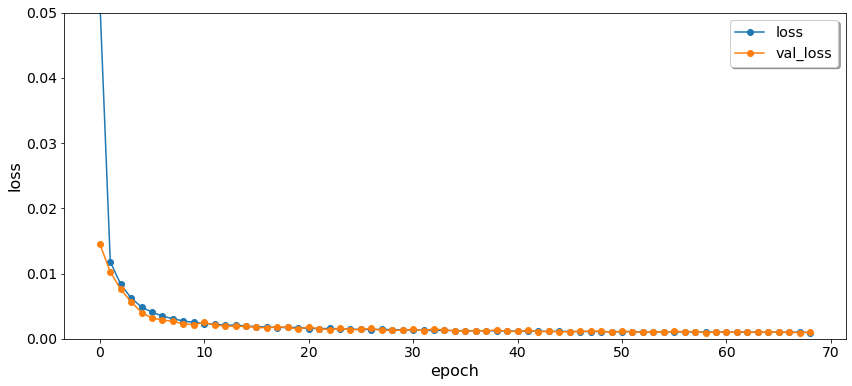

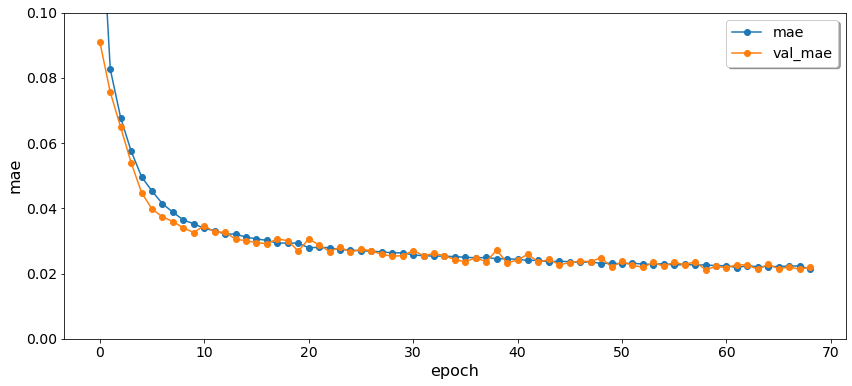

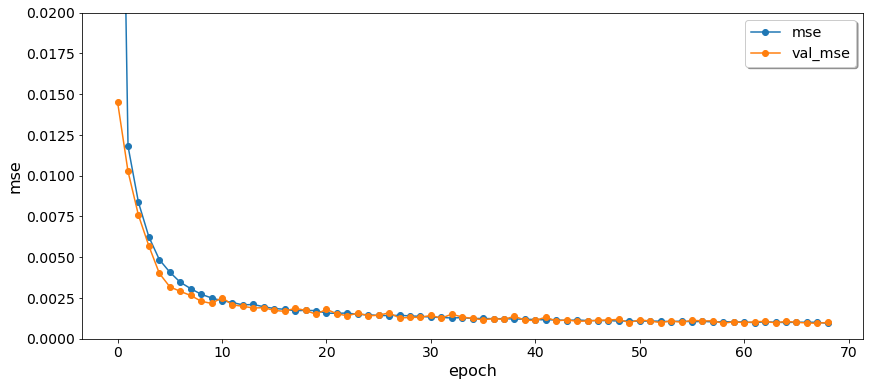

In [14]:
ANNscoreTrain2 = ANNmodel2.evaluate(x_train, y_train, verbose=0)
print(color.GREEN,color.GREEN,'x_train / loss      : {:5.4f}'.format(ANNscoreTrain2[0]))
print('x_train/ mae       : {:5.4f}'.format(ANNscoreTrain2[1]))
print('x_train / mse       : {:5.4f}'.format(ANNscoreTrain2[2]),color.OFF)
print()
ANNscoreEval2 = ANNmodel2.evaluate(x_test, y_test, verbose=0)
print(color.BLUE,color.BLUE,'x_test / loss      : {:5.4f}'.format(ANNscoreEval2[0]))
print('x_test / mae       : {:5.4f}'.format(ANNscoreEval2[1]))
print('x_test / mse       : {:5.4f}'.format(ANNscoreEval2[2]),color.OFF)

df=pd.DataFrame(data=ANNhistory2.history)
plt.rcParams["figure.figsize"] = (14,6)
figLOSS=df.plot(y=["loss","val_loss"],linestyle='-', marker='o',fontsize=14)
figLOSS.set_xlabel('epoch',fontdict={'fontsize':16})
figLOSS.set_ylabel('loss',fontdict={'fontsize':16})
figLOSS.set_ylim([0.0,0.05])
figLOSS.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-Loss_A.png',dpi=300,bbox_inches='tight')
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.1])
figMAE.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-MAE_A.png',dpi=300,bbox_inches='tight')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.02])
figMSE.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('figs/Model1-MSE_A.png',dpi=300,bbox_inches='tight')

#### **4.x.b.** Comparison between experimental and predicted CO<sub>2</sub> solubility

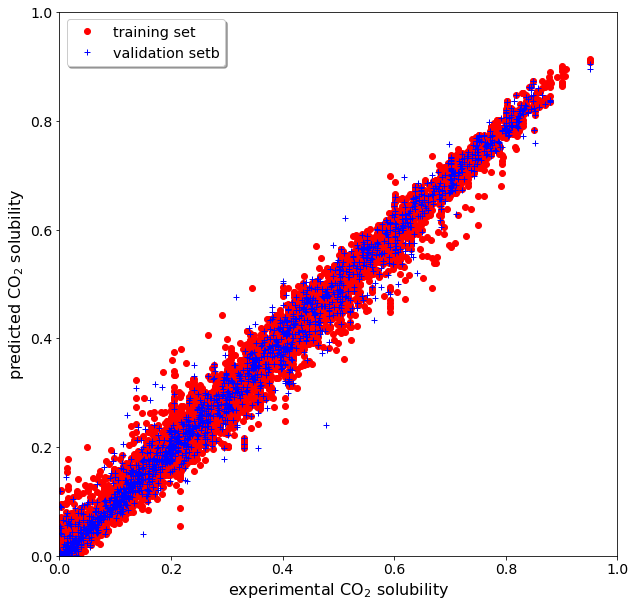

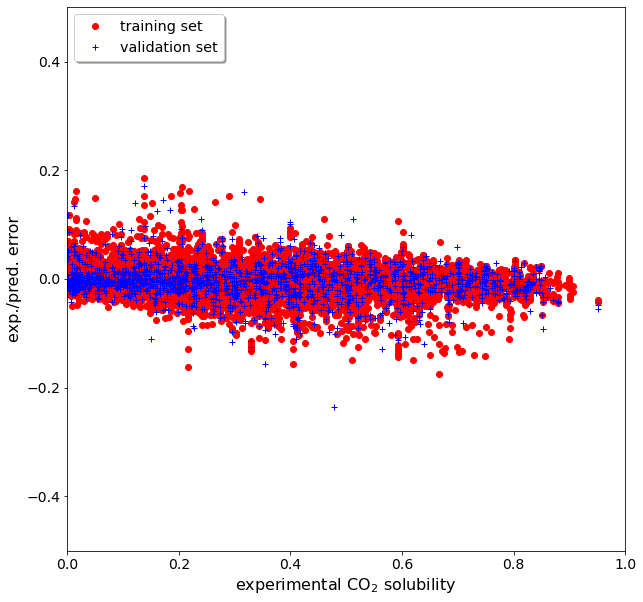

In [15]:
plt.rcParams["figure.figsize"] = (10,10)
ypredict_train2=ANNmodel2.predict(x_train)
ypredict_test2=ANNmodel2.predict(x_test)
diffyt2 = ypredict_train2.ravel() - y_train.ravel()
diffyp2 = ypredict_test2.ravel() - y_test.ravel()

figP, axP = plt.subplots()
axP.plot(y_train,ypredict_train2,'ro',label='training set')
axP.plot(y_test,ypredict_test2,'b+',label='validation setb')
axP.legend(loc='upper left', shadow=True, fontsize='x-large')
axP.set_xlim(0.0,1.0); axP.set_ylim(0.0,1.0)
axP.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
axP.set_ylabel('predicted CO$_2$ solubility',fontsize=16)
axP.tick_params(labelsize = 14)
plt.savefig('figs/Model1-Pred_vs_Exp_A.png',dpi=300,bbox_inches='tight')

figE, axE = plt.subplots()
axE.plot(y_train,diffyt2,'ro',label='training set')
axE.plot(y_test,diffyp2,'b+',label='validation set')
axE.legend(loc='upper left', shadow=True, fontsize='x-large')
axE.set_xlim(0.0,1.0); axE.set_ylim(-0.5,0.5)
axE.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
axE.set_ylabel('exp./pred. error',fontsize=16)
axE.tick_params(labelsize = 14)
plt.savefig('figs/Model1-Error_vs_Exp_A.png',dpi=300,bbox_inches='tight')

#### **4.x.c.** Distribution of the error

 Train. mean: -0.005    std: 0.030    MAE: 0.021     R2: 0.992
  Test. mean: -0.004    std: 0.031    MAE: 0.022     R2: 0.991


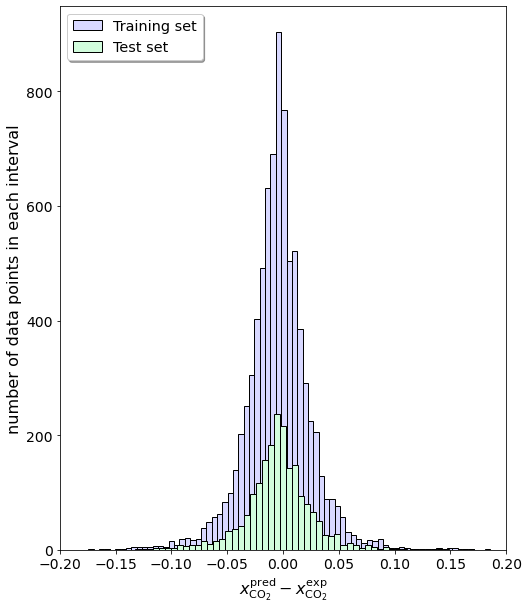

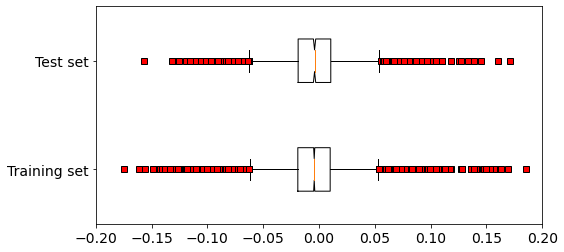

In [16]:
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt2)),
      "   std: {:.3f}".format(np.std(diffyt2)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt2))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ypredict_train2.ravel())[0,1])
     )
print(color.GREEN,
      " Test.","mean: {:.3f}".format(np.mean(diffyp2)),
      "   std: {:.3f}".format(np.std(diffyp2)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp2))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ypredict_test2.ravel())[0,1])
     )

figH, axH = plt.subplots(figsize=(8, 10))
axH.tick_params(labelsize = 14)
axH.hist(diffyt2, 75, cumulative=False,label='Training set',color='#d8d8ff', edgecolor='black',align='mid')
axH.hist(diffyp2, 75, cumulative=False,label='Test set',color='#d2fddd',edgecolor='black',align='mid')
axH.set_xlim(-0.2,0.2);
axH.legend(loc='upper left', shadow=True, fontsize='x-large')
axH.set_xlabel('$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$',fontsize=16)
axH.set_ylabel('number of data points in each interval',fontsize=16)
plt.savefig('figs/Model1-Histogram-error_A.png',dpi=300,bbox_inches='tight')

figB, axB = plt.subplots(figsize=(8, 4))
axB.tick_params(labelsize = 14)
red_square = dict(markerfacecolor='r', marker='s')
axB.boxplot((diffyt2,diffyp2), widths=(0.4,0.4), notch=True, vert=False,labels=('Training set','Test set'),flierprops=red_square)
axB.set_xlim(-0.2,0.2);
plt.savefig('figs/Model1-Boxplot-error_A.png',dpi=300,bbox_inches='tight')


#### **4.x.d.** Distribution of the error (seaborn graphics)

 Train. mean: -0.005    std: 0.030    MAE: 0.021     R2: 0.992
  Test. mean: -0.004    std: 0.031    MAE: 0.022     R2: 0.991


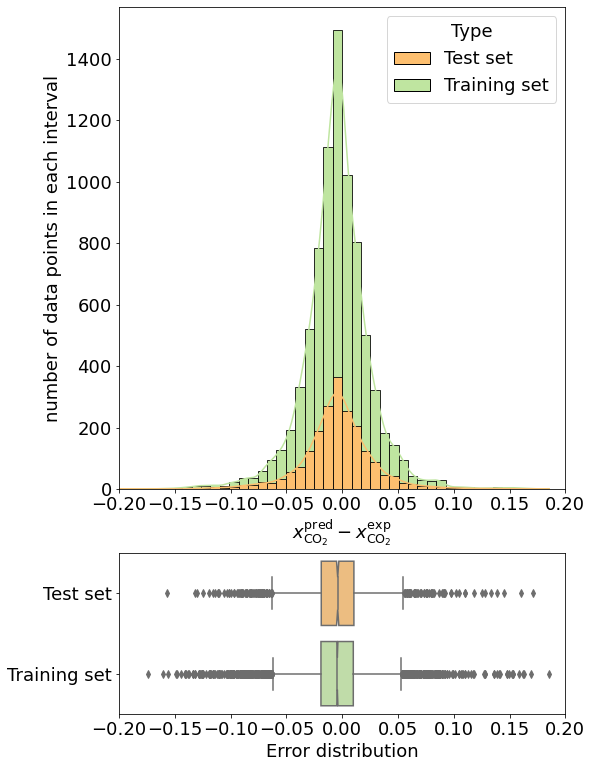

In [17]:
import seaborn as sb
from matplotlib import gridspec
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt2)),
      "   std: {:.3f}".format(np.std(diffyt2)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt2))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ypredict_train2.ravel())[0,1])
     )
print(color.GREEN,
      " Test.","mean: {:.3f}".format(np.mean(diffyp2)),
      "   std: {:.3f}".format(np.std(diffyp2)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp2))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ypredict_test2.ravel())[0,1])
     )

# make a dataframe
df1 = pd.DataFrame(
    {
        "Error distribution": diffyp2,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffyt2,
        "Type": 'Training set'    },
)
#display(df2)
distrib=pd.concat([df1,df2],ignore_index=True)
#display(distrib)

xlim=0.2
nbins=50
plt.rcParams["figure.figsize"] = (8,13) #on ajuste la taille du graphique
plt.rcParams["font.size"] = (18) #on ajuste la taille des caractères
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sb.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True, palette='Spectral', alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sb.boxplot(data=distrib, x="Error distribution", y="Type", notch=True, orient = 'h',palette='Spectral')
fig2.set(ylabel=None)
plt.savefig('figs/Model1-Histogram-error_A.png',dpi=300,bbox_inches='tight')


## Appendix

### <a id="activation-functions"></a>Activation functions

In [ ]:
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
pw=5
ph=5

#### Relu function

In [ ]:
def relu(z):
    return np.maximum(0, z)

figR, axR = plt.subplots(1, 1)
figR.set_size_inches(pw,ph)
axR.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axR.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axR.plot(z, relu(z),linewidth=4,label="ReLU")
axR.plot(z, derivative(relu, z), linewidth=4, alpha=0.6, label="dReLU/dx")
axR.legend(loc='upper left', shadow=True, fontsize='x-large')
axR.set_xlabel('x',fontdict={'fontsize':16})
axR.set_ylabel('f(x)',fontdict={'fontsize':16})
axR.set_xlim(-5, 5)
axR.set_ylim(-0.5, 2)
axR.tick_params(labelsize = 14)
plt.savefig('figs/relu.png',dpi=300,bbox_inches='tight')
plt.show()


#### tanh function

In [ ]:
def tanh(z):
    return np.tanh(z)

figT, axT = plt.subplots(1, 1)
figT.set_size_inches(pw,ph)
axT.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axT.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axT.plot(z, tanh(z),linewidth=4,label="tanh")
axT.plot(z, derivative(tanh, z), linewidth=4, alpha=0.6, label="dtanh/dx")
axT.legend(loc='upper left', shadow=True, fontsize='x-large')
axT.set_xlabel('x',fontdict={'fontsize':16})
axT.set_ylabel('f(x)',fontdict={'fontsize':16})
axT.set_xlim(-5, 5)
axT.set_ylim(-2, 2)
axT.tick_params(labelsize = 14)
plt.savefig('figs/tanh.png',dpi=300,bbox_inches='tight')
plt.show()


### Calculation of Extended-Connectivity Fingerprints (ECFPs)

In [ ]:
import rdkit
from rdkit.Chem import AllChem
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd

print(rdkit.__version__)

#### Show the cations and anions (conversion of smiles in "RoMol" format)

In [ ]:
from molvs import standardize_smiles
fSMILESCO2='dataCO2_solubility'+'/'+'dataCO2_SMILES_ILsList.csv'
SMILESCO2=pd.read_csv(fSMILESCO2,sep="\t",header=0)
display(SMILESCO2.head(2))
ILanion=SMILESCO2[SMILESCO2['Cation or Anion'] == 'Anion']
print(ILanion.shape)
display(ILanion)
smiles2 = [standardize_smiles(i) for i in ILanion['SMILES'].values]
#print(smiles2)
#DataFrame.insert, inserts a column into DataFrame at specified idexed location
ILanion.insert(loc=4, column='STANDARDIZED SMILES', value=smiles2)
display(ILanion)
print(ILanion.shape)
#AddMoleculeColumnToFrame converts the molecules contained in “smilesCol”
#to RDKit molecules and appends them to the dataframe “frame” using the specified column name (default: 'ROMol')
PandasTools.AddMoleculeColumnToFrame(ILanion, smilesCol='STANDARDIZED SMILES')
display(ILanion)
IPythonConsole.drawOptions.bondLineWidth=1
#FrameToGridImage: Draw grid image of mols in pandas DataFrame
PandasTools.FrameToGridImage(ILanion, molsPerRow=3, legendsCol='Abbreviation', useSVG=True, subImgSize=(400, 200), maxMols=ILanion.shape[0])

#### Use of the `ECPF6.py` utility provided on the [Zin's website](https://drzinph.com/ecfp6-fingerprints-in-python-part-3/) 

In [ ]:
from molvs import standardize_smiles
from ECFP6 import *

#display(df)
smiles = ILanion['SMILES'].values
#print(smiles)

smiles2 = [standardize_smiles(i) for i in ILanion['SMILES'].values]
print(smiles2)
ecfp6_descriptor = ECFP6(smiles2)
ecfp6_descriptor.compute_ECFP6(fSMILESCO2)

#### Direct use of the Morgan fingerprint available in RDKit ([found on an RDKit cheatsheet](https://xinhaoli74.github.io/posts/2020/04/RDKit-Cheatsheet/))

In [ ]:
display(ILanion)
radius=3
nBits=2048
ECFP6Anion = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in ILanion['ROMol']]
print(ECFP6Anion[0],"length:",len(ECFP6Anion[0]))
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6Anion]
df_morgan = pd.DataFrame(ecfp6_bits, index = ILanion['STANDARDIZED SMILES'], columns=ecfp6_name)
df_morgan.head(1)
fECFP6=fSMILESCO2[:-4]+"_ECFP6b.csv"
df_morgan.to_csv(fECFP6,sep='\t',index=True)

#### Morgan fingerprint available in RDKit > application to the dataCO2_SMILES_ILsList
<div class="rq">Will be done once and for all</div>

In [ ]:
from molvs import standardize_smiles
fSMILES_ILs='dataCO2_solubility'+'/'+'dataCO2_SMILES_ILsList.csv'
SMILES_ILs=pd.read_csv(fSMILES_ILs,sep="\t",header=0)
print("SMILES_ILs")
display(SMILES_ILs.head(2))
print(SMILES_ILs.shape)

smiles2 = [standardize_smiles(i) for i in SMILES_ILs['SMILES'].values]
#print(smiles2)
#DataFrame.insert, inserts a column into DataFrame at specified idexed location
SMILES_ILs.insert(loc=4, column='Std SMILES', value=smiles2)
print("SMILES_ILs after insertion of standardized SMILES")
display(SMILES_ILs)
print(SMILES_ILs.shape)

#AddMoleculeColumnToFrame converts the molecules contained in “smilesCol”
#to RDKit molecules and appends them to the dataframe “frame” using the specified column name (default: 'ROMol')
PandasTools.AddMoleculeColumnToFrame(SMILES_ILs, smilesCol='Std SMILES')
print("SMILES_ILs after AddMoleculeColumnToFrame (i.e. generation of ROMol decription)")
display(SMILES_ILs)

# now is done the ECFP6 generation
radius=3
nBits=2048
ECFP6ILsBV = [AllChem.GetMorganFingerprintAsBitVect(x,radius=radius, nBits=nBits) for x in SMILES_ILs['ROMol']]
#ECFP6ILs = [AllChem.GetMorganFingerprint(x,radius=radius) for x in SMILES_ILs['ROMol']]
print(ECFP6ILsBV[0],"length:",len(ECFP6ILsBV[0]))
ecfp6_name = [f'B_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6ILsBV]
df_morgan = pd.DataFrame(ecfp6_bits, index = SMILES_ILs['Std SMILES'], columns=(ecfp6_name))
print("df_morgan")
display(df_morgan.head(2))
df_morgan.reset_index(drop=True, inplace=True)
print("df_morgan after index reset")
display(df_morgan.head(2))
#ecfp6_FP = [list(l) for l in ECFP6ILs]
#df_morganFP = pd.DataFrame(ecfp6_FP, index = SMILES_ILs['Std SMILES'], columns=("ECFP6"))
#print("df_morganFP")
#display(df_morganFP.head(2))
dftmp = pd.concat([SMILES_ILs,df_morgan], axis=1)
dftmp=dftmp.drop(['ROMol'],axis=1)
print("dftmp")
display(dftmp)
fECFP6=fSMILES_ILs[:-4]+"_ECFP6Morgan.csv"
dftmp.to_csv(fECFP6,sep='\t',index=False)
del dftmp

### Prediction of the solubility of CO<sub>2</sub> by deep learning: **minimal python code**

In [4]:
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import pandas as pd
from IPython.display import display

#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas

dataCO2='dataCO2_solubility'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2,sep=";",header=0)
display(dataCO2)

data_train = dataCO2.sample(frac=0.8, axis=0)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def get_model_C(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(20, activation=acthL, name='hLayer1'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer2'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

#######################################################################################
# optimization of the ANN
# library used: still keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
acthL='tanh'
ANNmodel2=get_model_C( (53,), acthL )
ANNmodel2.summary()
vID.chrono_start()
ANNhistory2 = ANNmodel2.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ypredict_train2=ANNmodel2.predict(x_train)
ypredict_test2=ANNmodel2.predict(x_test)
diffyt2 = ypredict_train2.ravel() - y_train.ravel()
diffyp2 = ypredict_test2.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt2),
      "   std: ", np.std(diffyt2),
      "   MAE: ", np.average(abs(diffyt2)),
      "    R2: ", np.corrcoef(y_train.ravel(),ypredict_train2.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp2),
      "   std: ", np.std(diffyp2),
      "   MAE: ", np.average(abs(diffyp2)),
      "    R2: ", np.corrcoef(y_test.ravel(),ypredict_test2.ravel())[0,1]
     )

#######################################################################################
# save model for later use

!mkdir -p saved_models
ANNmodel2.save('saved_models/ANNmodel-basic')

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


2022-06-15 17:34:40.478815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hLayer1 (Dense)             (None, 20)                1080      
                                                                 
 hLayer2 (Dense)             (None, 7)                 147       
                                                                 
 oLayer (Dense)              (None, 1)                 8         
                                                                 
Total params: 1,235
Trainable params: 1,235
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
810/810 [==============================] - 2s 2ms/step - loss: 0.0278 - mae: 0.1243 - mse: 0.0278 - val_loss: 0.0179 - val_mae: 0.1048 - val_mse: 0.0179
Epoch 2/200
810/810 [==============================] - 1s 1ms/step - loss: 0.0158 - mae: 0.0965 - mse: 0.0158 - val_loss: 0.0151 - val_mae: 0.0949 - val_

2022-06-15 17:35:28.504464: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/ANNmodel-basic/assets


INFO:tensorflow:Assets written to: saved_models/ANNmodel-basic/assets


In [ ]:
vID.end()